# UDS emulator 

## Preliminaries

In [1]:
from my_imports import *

## Read data - Create dataset

In [2]:
#Rainfall
rainfall_raw_data = utils.get_rain_in_pandas(rain_path)

#Hydraulic head
head_raw_data = utils.get_info_from_pickle(heads_path)
head_raw_data.columns = head_raw_data.columns.str.replace("_Hydraulic_head", "")
head_raw_data.columns = head_raw_data.columns.str.replace("node_", "")

#### Couples of training events

In [3]:
couples_x0_ht_1steps = utils.get_x0_ht_couples(rainfall_raw_data,head_raw_data, steps_ahead = 1)
couples_x0_ht_6steps = utils.get_x0_ht_couples(rainfall_raw_data,head_raw_data, steps_ahead = 6)

#samples
#[0 to N samples]
#   [0]: x0
#       [0]:rainfall values for all the timesteps (including t=0) 
#       [1]:dictionary with initial depth (h0)
#   [1]: y0 -> List of dictionaries containing depth at times > 0

#### Rolled-out validation event

In [4]:
# rolled_out_target_hydraulic_heads = []

# for dry_period in val_dry_period_indexes:
#     heads_no_rain = head_raw_data.iloc[list(dry_period), :]
#     heads = utils.get_rolled_out_target_hydraulic_heads(heads_no_rain)
    
#     rolled_out_target_hydraulic_heads.append(heads)

## Separate samples in training/validation/testing

In [5]:
x_values = [i[0] for i in couples_x0_ht_6steps]
y_values = [i[1] for i in couples_x0_ht_6steps]

In [6]:
# set aside 20% of train and test data for evaluation
X_train, X_test, y_train, y_test = train_test_split(x_values, y_values,
    test_size=0.2, shuffle = True, random_state = 8)

# Use the same function above for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2

## Data preprocessing

### Normalization

In [7]:
#It considers all heads with the same scaling
norm = utils.Normalizer(X_train, y_train)

normalized_x = norm.initial_heads
normalized_y = norm.normalized_ht_in_y

### Visualization

In [8]:
# For a single node
node_name = 'j_90492'
single_node_x = []
single_node_y = []
length_database = len(normalized_x) #same as y_train
step=1
for i in range(length_database):
    single_node_x.append(normalized_x[i][node_name])
    single_node_y.append(normalized_y[i][step-1][node_name])


In [9]:
fig = utils.plot_head_changes(node_name, single_node_x, single_node_y)
fig.show()

## Model

### Artificial Neural Network definition

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [11]:
q_transfer_ANN = QInterchangeNN().to(device)
q_runoff_ANN = QRunoffNN().to(device)

### Model definition

In [12]:
wn = DE.DynamicEmulator(inp_path, q_transfer_ANN, q_runoff_ANN)


There are no [STORAGE]
 in the file
The file does not have pumps. A handled exception occured because of '[PUMPS]\n'
The file does not have orifices. A handled exception occured because of '[ORIFICES]\n'
The file does not have weirs. A handled exception occured because of '[WEIRS]\n'


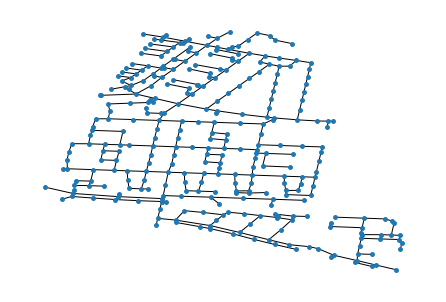

In [13]:
#Draw graph
wn.draw_nx_layout()

### Dynamic emulator

In [14]:
wn.set_h(X_train[0][1])
columns = ['Time' , 'Node', 'Depth', 'x_coord' , 'y_coord']
df = pd.DataFrame(wn.get_depths_to_rows(0), columns = columns)

for time in range(5):
    wn.update_h(rain = (X_train[0][0][time])/40) 
    new_h_rows = pd.DataFrame(wn.get_depths_to_rows(time+1), columns = columns)
    df = pd.concat([df,new_h_rows])

<AxesSubplot:>

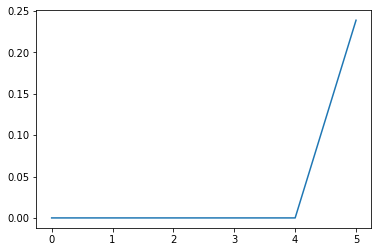

In [15]:
depth_one_node = df[df['Node']=='j_90376']['Depth'] #.plot() j_90550
depth_one_node=depth_one_node.reset_index()
depth_one_node['Depth'].plot()

In [16]:
net = utils.animate_nodal_depth(df)
net.show()

In [17]:
# net.write_html('09_06_2022_Depth_dynamic_viz.html')

### Model training

In [18]:
optimizer1 = optim.SGD(wn.q_transfer_ANN.parameters(), lr=0.001, momentum=0.9)
optimizer2 = optim.SGD(wn.q_runoff_ANN.parameters(), lr=0.001, momentum=0.9)
losses=[]

for epoch in range(20):
    epoch_losses =[]
    for i in range(len(X_train)):
        
        wn.set_h(X_train[i][1])

        for time in range(1):
            wn.update_h(rain = (X_train[i][0][time])/40) 

        pred = torch.cat(list(wn.get_h().values()))
        target = torch.reshape(torch.tensor(list(y_train[i][0].values())), (-1,1))

        loss = nn.MSELoss()(pred, target)
        epoch_losses.append(loss.detach())
        
        if loss.requires_grad:
            # Backpropagate and update weights
            loss.backward()
            optimizer1.step()
            optimizer1.zero_grad(set_to_none=True) 

            optimizer2.step()
            optimizer2.zero_grad(set_to_none=True)
              
    losses.append(np.array(epoch_losses).mean())

<AxesSubplot:>

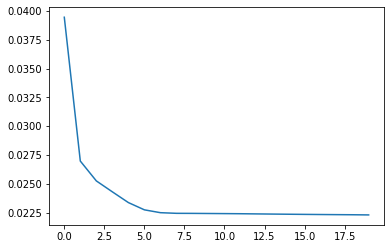

In [19]:
pd.Series(np.array(losses)).plot()



### Model validation

In [20]:
wn.set_h(X_train[0][1])
columns = ['Time' , 'Node', 'Depth', 'x_coord' , 'y_coord']
df = pd.DataFrame(wn.get_depths_to_rows(0), columns = columns)

for time in range(5):
    wn.update_h(rain = (X_train[0][0][time])/40) 
    new_h_rows = pd.DataFrame(wn.get_depths_to_rows(time+1), columns = columns)
    df = pd.concat([df,new_h_rows])

<AxesSubplot:>

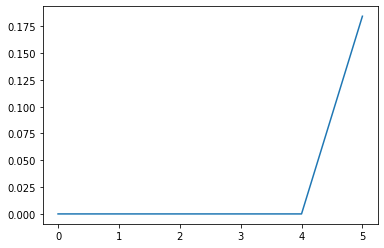

In [21]:
depth_one_node = df[df['Node']=='j_90376']['Depth'] #.plot() j_90550
depth_one_node=depth_one_node.reset_index()
depth_one_node['Depth'].plot()

In [22]:
net = px.scatter(
                df, 
                x="x_coord", 
                y="y_coord", 
                size="Depth", 
                animation_frame="Time", 
                size_max=20, 
                hover_name="Node",
                width=500, 
                height=800
                )
net.show()

In [23]:
net.write_html('3Trained_Depth_dynamic_viz.html')

### Model testing

## Predictions visualization

## Export model

# Scratchpad

In [26]:
# X_train[0][0]

[0, 0, 0, 0, 20, 20, 20]

In [28]:
len(normalized_x)

47